In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt  
import itertools
import random
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## DataLoader

In [2]:
### handle the dataset
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label
    def __len__(self):
        return self.trace_num
    
### data loader for training
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
    return train_loader

### data loader for testing
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)
    return test_loader

## Arrays and Functions

In [3]:
Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]

HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
            3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
            3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
            4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
            3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
            6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
            4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
            6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]

### To train a network 
def train(epoch, model, scheduler):
    """
    - epoch : the current epoch
    - model : the current model 
    - learning_rate : learning rate   
    """
    model.train() # enter training mode 
    # Instantiate the Iterator
    iter_source = iter(source_train_loader)
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        source_data, source_label = iter_source.next()
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        optimizer.zero_grad()
        source_preds = model(source_data)
        preds = source_preds.data.max(1, keepdim=True)[1]
        correct_batch = preds.eq(source_label.data.view_as(preds)).sum()
        loss = clf_criterion(source_preds, source_label)
        # optimzie the cross-entropy loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size,
                100. * i / len(source_train_loader), loss.data, float(correct_batch) * 100. /batch_size))
    
### validation 
def validation(model):
    # enter evaluation mode
    model.eval()
    valid_loss = 0
    # the number of correct prediction
    correct_valid = 0
    clf_criterion = nn.CrossEntropyLoss()
    for data, label in source_valid_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        valid_preds = model(data)
        # sum up batch loss
        valid_loss += clf_criterion(valid_preds, label) 
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        # get the number of correct prediction
        correct_valid += pred.eq(label.data.view_as(pred)).cpu().sum()
    valid_loss /= len(source_valid_loader)
    valid_acc = 100. * correct_valid / len(source_valid_loader.dataset)
    print('Validation: loss: {:.4f}, accuracy: {}/{} ({:.6f}%)'.format(
        valid_loss.data, correct_valid, len(source_valid_loader.dataset),
        valid_acc))
    return valid_loss, valid_acc

### test/attack
def test(model, device_id, disp_GE=True, model_flag='pretrained'):
    """
    - model : the current model 
    - device_id : id of the tested device
    - disp_GE : whether to attack/calculate guessing entropy (GE)
    - model_flag : a string for naming GE result
    """
    # enter evaluation mode
    model.eval()
    test_loss = 0
    # the number of correct prediction
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()
    if device_id == source_device_id: # attack on the source domain
        test_num = source_test_num
        test_loader = source_test_loader
        real_key = real_key_01
    else: # attack on the target domain
        test_num = target_test_num
        test_loader = target_test_loader
        real_key = real_key_02
    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((test_num, class_num), dtype=torch.float, device='cpu')
    for data, label in test_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        test_preds = model(data)
        # sum up batch loss
        test_loss += clf_criterion(test_preds, label) 
        # get the index of the max probability
        pred = test_preds.data.max(1)[1]
        # get the softmax results for attack/showing guessing entropy
        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch*batch_size:(epoch+1)*batch_size, :] =softmax(test_preds)
        # get the predictions (predlist) and real labels (lbllist) for showing confusion matrix
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        # get the number of correct prediction
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1
    test_loss /= len(test_loader)
    print('test loss: {:.4f}, test accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # get the confusion matrix
    #confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy(), labels=range(class_num))
    # show the confusion matrix
    #plot_sonfusion_matrix(confusion_mat, classes = range(class_num))
    # show the guessing entropy and success rate
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, device_id, model_flag)
    return test_loss    
        
### show the guessing entropy and success rate
def plot_guessing_entropy(preds, real_key, device_id, model_flag):
    """
    - preds : the probability for each class (n*256 for a byte, n*9 for Hamming weight)
    - real_key : the key of the target device
    - device_id : id of the target device
    - model_flag : a string for naming GE result
    """
    # GE/SR is averaged over 100 attacks 
    num_averaged = 100
    # max trace num for attack
    trace_num_max = 500
    # the step trace num increases
    step = 1
    if trace_num_max > 400 and trace_num_max < 1000:
        step = 2
    if trace_num_max >= 1000 and trace_num_max < 5000:
        step = 4
    if trace_num_max >= 5000 and trace_num_max < 10000:
        step = 5
    guessing_entropy = np.zeros((num_averaged, int(trace_num_max/step)))
    success_flag = np.zeros((num_averaged, int(trace_num_max/step)))
    if device_id == target_device_id:# attack on the target domain
        plaintext = plaintexts_target
    elif device_id == source_device_id:# attack on the source domain
        plaintext = plaintexts_source
    # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index = list(range(plaintext.shape[0]))
        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = int(plaintext[random_index[i]]) ^ key_guess
                sout = Sbox[initialState]
                if labeling_method == 'identity':
                    label = sout
                elif labeling_method == 'hw':
                    label = HW_byte[sout]
                score_mat[i, key_guess] = preds[random_index[i], label]
        score_mat = np.log(score_mat + 1e-40)
        for i in range(0, int(trace_num_max/step)):
            log_likelihood = np.sum(score_mat[0:i*step+1,:], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time,i] =  list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                    success_flag[time, i] = 1
    guessing_entropy = np.mean(guessing_entropy,axis=0)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 1, 1)
    x = range(0, trace_num_max, step)
    p1, = plt.plot(x, guessing_entropy[0:int(trace_num_max/step)],color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Guessing entropy')
    plt.show()
    #np.save('./results/bilinear_entropy_'+ labeling_method + '_ctf_' + model_flag + '_'+ desync, guessing_entropy)

### show the confusion matrix
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar() 
    plt.ylim((len(classes)-0.5, -0.5))
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()
    
# correlation of matrix X and Y
def Matrix_Cor(X, Y):
    if X.shape[0] != Y.shape[0]:
        print("X and Y have wrong shape")
        return
#     print(
#         "Start calculating the correlation between power trace and intermedia data_file_path"
#     )
    N, col_X = X.shape
    col_Y = Y.shape[1]

    Sum_of_X = X.sum(axis=0)
    # print(Sum_of_X.shape)
    Sum_of_Y = Y.sum(axis=0)
    # print(Sum_of_Y.shape)
    Sum_of_X2 = (X * X).sum(axis=0)
    # print(Sum_of_X2.shape)
    Sum_of_Y2 = (Y * Y).sum(axis=0)
    # print(Sum_of_Y2.shape)
    Sum_of_XY = (X.T).dot(Y)
    # print(Sum_of_XY.shape)

    r = N * Sum_of_XY - Sum_of_X.reshape(
        (col_X, 1)).dot(Sum_of_Y.reshape(1, col_Y))
    r = r / np.sqrt(
        (N * Sum_of_X2 - Sum_of_X * Sum_of_X).reshape(col_X, 1).dot(
            (N * Sum_of_Y2 - Sum_of_Y * Sum_of_Y).reshape(1, col_Y)))
#     print(
#         "Finished.The correlation matrix is retured.\nPlease run CPA(result=result) to see the key rank."
#     )
    return r.T

## Setups

In [4]:
source_device_id = 0
target_device_id = 1
real_key_01 = 23 # key of the source domain
real_key_02 = 46 # key of the target domain
labeling_method = 'identity' # labeling of trace
preprocess = 'feature_standardization' # preprocess method
batch_size = 100
total_epoch = 50
lr = 0.005 # learning rate
log_interval = 100 # epoch interval to log training information
train_num = 43000
valid_num = 1000
source_test_num = 1000
target_test_num = 5000
trace_offset = 0
trace_length = 2200
desync = '_device_c_to_d'
source_file_path = './data/Device_C/'
target_file_path = './data/Device_D/'
no_cuda =False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9

# to load traces and labels
X_train_source = np.load(source_file_path + 'X_train.npy')
Y_train_source = np.load(source_file_path + 'Y_train_id.npy')
X_attack_source = np.load(source_file_path + 'X_attack.npy')
Y_attack_source = np.load(source_file_path + 'Y_attack_id.npy')
X_attack_target = np.load(target_file_path + 'X_attack.npy')
Y_attack_target = np.load(target_file_path + 'Y_attack_id.npy')

# to load plaintexts
plaintexts_source = np.load(source_file_path + 'plaintexts_attack.npy')
plaintexts_source = plaintexts_source[:]
plaintexts_target = np.load(target_file_path + 'plaintexts_attack.npy')
plaintexts_target = plaintexts_target[0:target_test_num]
    
# preprocess of traces
if preprocess == 'feature_standardization':
    scaler = preprocessing.StandardScaler()
    X_train_source = scaler.fit_transform(X_train_source)
    X_attack_source = scaler.transform(X_attack_source)
    
    X_attack_target = scaler.fit_transform(X_attack_target)
elif preprocess == 'feature_scaling':
    scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    X_train_source = scaler.fit_transform(X_train_source)
    X_attack_source = scaler.transform(X_attack_source)
    
    X_attack_target = scaler.fit_transform(X_attack_target)
elif preprocess == 'horizontal_standardization':
    mn = np.repeat(np.mean(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    std = np.repeat(np.std(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    X_train_source = (X_train_source - mn)/std

    mn = np.repeat(np.mean(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    X_attack_source = (X_attack_source - mn)/std
    
    mn = np.repeat(np.mean(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    X_attack_target = (X_attack_target - mn)/std
    
elif preprocess == 'horizontal_scaling':
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_train_source.T)
    X_train_source = scaler.transform(X_train_source.T).T

    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_source.T)
    X_attack_source = scaler.transform(X_attack_source.T).T
    
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_target.T)
    X_attack_target = scaler.transform(X_attack_target.T).T

# parameters of data loader
kwargs_source_train = {
        'trs_file': X_train_source[0:train_num,:],
        'label_file': Y_train_source[0:train_num],
        'trace_num':train_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_valid = {
        'trs_file': X_train_source[train_num:train_num+valid_num,:],
        'label_file': Y_train_source[train_num:train_num+valid_num],
        'trace_num':valid_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_test = {
        'trs_file': X_attack_source,
        'label_file': Y_attack_source,
        'trace_num':source_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target = {
        'trs_file': X_attack_target[0:target_test_num, :],
        'label_file': Y_attack_target[0:target_test_num],
        'trace_num':target_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
source_train_loader = load_training(batch_size, kwargs_source_train)
source_valid_loader = load_training(batch_size, kwargs_source_valid)
source_test_loader = load_testing(batch_size, kwargs_source_test)
target_test_loader = load_testing(batch_size, kwargs_target)
print('Load data complete!')

Load data complete!


## Models

In [5]:
### the pre-trained model
class Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 2, kernel_size=1),
            nn.SELU(),
            nn.BatchNorm1d(2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(2200, 10),
            nn.Dropout(0.25),
            nn.SELU(),
        )
        # the fully-connected layer 2
        self.classifier_2 = nn.Sequential(
            nn.Linear(100, 20),
            nn.Dropout(0.25),
            nn.SELU()
        )
        # the fully-connected layer 3
        self.classifier_3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
    
    # how the network runs
    def forward(self, input):
        x1 = self.features(input)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.classifier_1(x1)
        x = torch.bmm(x1.unsqueeze(2), x1.unsqueeze(1))
        x = x.view(-1, x1.size(1) **2)
        x = self.classifier_2(x)
        x = self.classifier_3(x)
        output = self.final_classifier(x)
        return output

# train

In [6]:
# create a network
pretrained_model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    pretrained_model.cuda()
# initialize a big enough loss number
min_loss = 1000
# load the pre-trained model
optimizer = optim.Adam([
        {'params': pretrained_model.features.parameters()},
        {'params': pretrained_model.classifier_1.parameters()},
        {'params': pretrained_model.classifier_2.parameters()},
        {'params': pretrained_model.classifier_3.parameters()},
        {'params': pretrained_model.final_classifier.parameters()}
    ], lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(source_train_loader), pct_start=0.1,anneal_strategy='linear', cycle_momentum=False,epochs=total_epoch, div_factor=10, verbose=False)
for epoch in range(1, total_epoch + 1):
    print(f'Train Epoch {epoch}:')
    train(epoch, pretrained_model, scheduler)
    with torch.no_grad():
        valid_loss, _ = validation(pretrained_model)
        # save the model that achieves the lowest validation loss
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': pretrained_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './models/CHES_CTF_ID.pth')

Construct model complete
Train Epoch 1:
Train Epoch 1: [10000/43000 (23%)]	Loss: 5.564281	Acc: 0.000000%
Train Epoch 1: [20000/43000 (47%)]	Loss: 5.595173	Acc: 0.000000%
Train Epoch 1: [30000/43000 (70%)]	Loss: 5.592703	Acc: 1.000000%
Train Epoch 1: [40000/43000 (93%)]	Loss: 5.546845	Acc: 0.000000%
Validation: loss: 5.5613, accuracy: 5/1000 (0.500000%)
Train Epoch 2:
Train Epoch 2: [10000/43000 (23%)]	Loss: 5.549942	Acc: 2.000000%
Train Epoch 2: [20000/43000 (47%)]	Loss: 5.557194	Acc: 0.000000%
Train Epoch 2: [30000/43000 (70%)]	Loss: 5.538958	Acc: 0.000000%
Train Epoch 2: [40000/43000 (93%)]	Loss: 5.542610	Acc: 0.000000%
Validation: loss: 5.5550, accuracy: 2/1000 (0.200000%)
Train Epoch 3:
Train Epoch 3: [10000/43000 (23%)]	Loss: 5.558990	Acc: 0.000000%
Train Epoch 3: [20000/43000 (47%)]	Loss: 5.543561	Acc: 0.000000%
Train Epoch 3: [30000/43000 (70%)]	Loss: 5.524746	Acc: 1.000000%
Train Epoch 3: [40000/43000 (93%)]	Loss: 5.548029	Acc: 0.000000%
Validation: loss: 5.5490, accuracy: 3/10

## Results of pre-trained model on source and target devices

Construct model complete
Result on source device:
test loss: 5.4943, test accuracy: 6/1000 (0.60%)



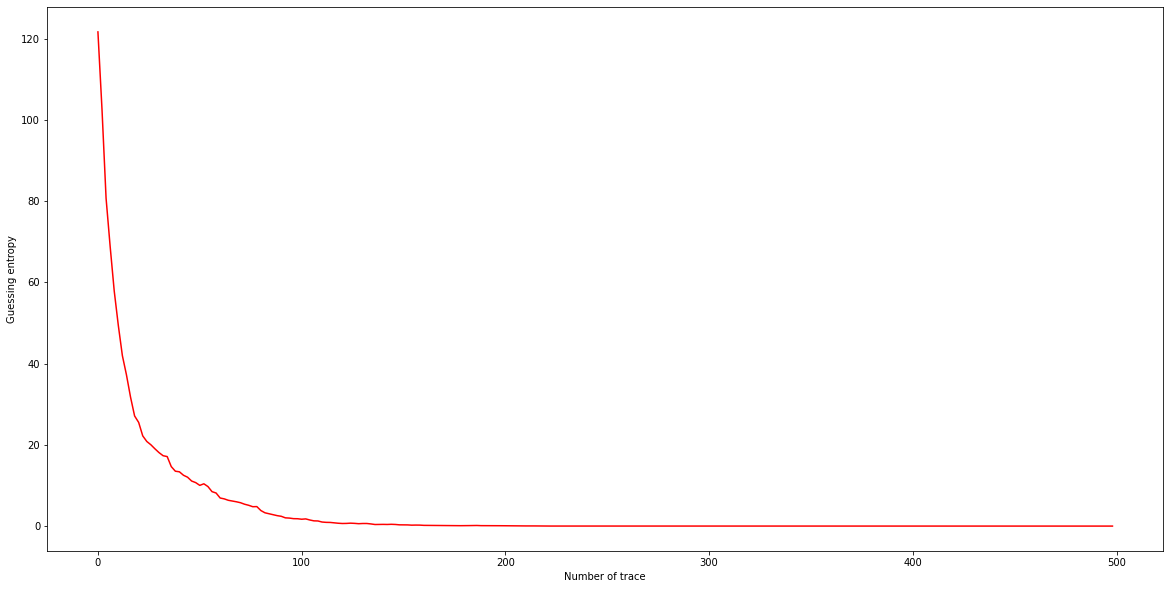

Result on target device:
test loss: 5.4916, test accuracy: 38/5000 (0.76%)



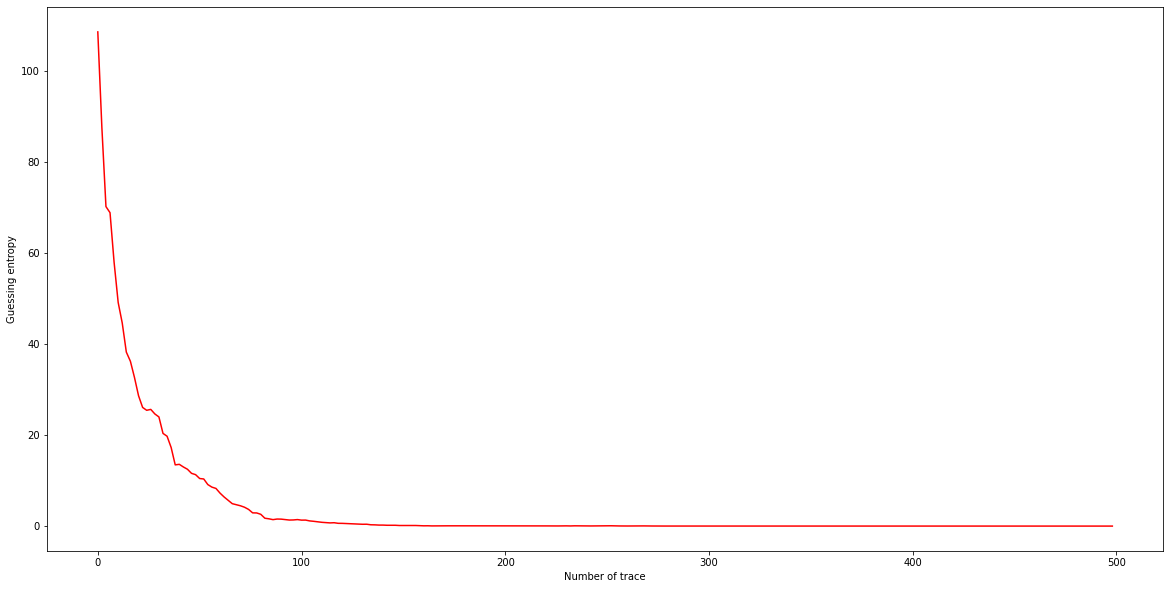

In [7]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network 
checkpoint = torch.load('./models/CHES_CTF_ID.pth')
pretrained_dict = checkpoint['model_state_dict']
model_dict = pretrained_dict
model.load_state_dict(model_dict)

# evaluate the pre-trained model on source and target domain
with torch.no_grad():
    
    print('Result on source device:')
    test(model, source_device_id, model_flag='pretrained_source')
    
    print('Result on target device:')
    test(model, target_device_id, model_flag='pretrained_target')
    

## size of the network

In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

29834

# Layer-wise correlation (LWC)

Construct model complete


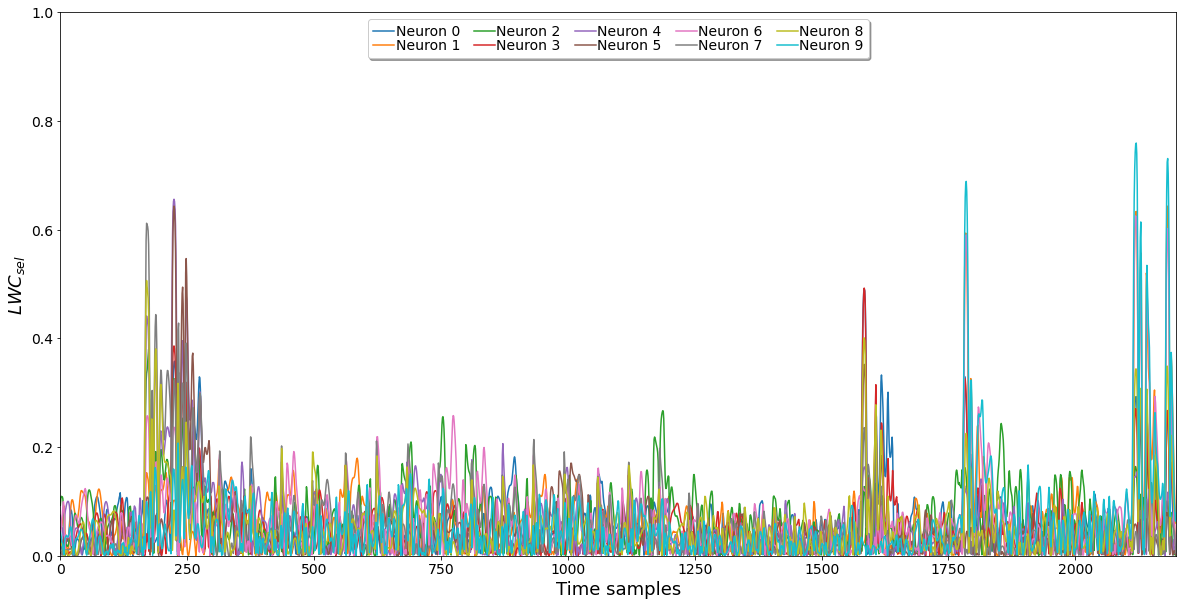

In [9]:
def get_layer_out(model):
    model.eval()
    iter_source = iter(train_loader_wo_shuffle)
    num_iter = len(train_loader_wo_shuffle)
    x0_output = np.zeros((train_num,2200),dtype=np.float64)
    x1_output = np.zeros((train_num,10),dtype=np.float64)
    bilinear_output = np.zeros((train_num,100),dtype=np.float64)
    x3_output = np.zeros((train_num,20),dtype=np.float64)
    x4_output = np.zeros((train_num,20),dtype=np.float64)
    final_output = np.zeros((train_num,class_num),dtype=np.float64)
    for i in range(1, num_iter+1):
        source_data, _ = iter_source.next()
        if cuda:
            source_data= source_data.cuda()
        source_data = Variable(source_data)
        x0_o, x1_o, bilinear_x2_o, x3_o, x4_o, final_o = model(source_data)
        x0_output[batch_size*(i-1):batch_size*i,:] = x0_o.cpu()
        x1_output[batch_size*(i-1):batch_size*i,:] = x1_o.cpu()
        bilinear_output[batch_size*(i-1):batch_size*i,:] = bilinear_x2_o.cpu()
        x3_output[batch_size*(i-1):batch_size*i,:] = x3_o.cpu()
        x4_output[batch_size*(i-1):batch_size*i,:] = x4_o.cpu()
        final_output[batch_size*(i-1):batch_size*i,:] = final_o.cpu()
    return x0_output, x1_output, bilinear_output,x3_output,x4_output, final_output

### network for getting layer output
class Net_Layer_out(nn.Module):
    def __init__(self, num_classes=class_num):
        super(Net_Layer_out, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 2, kernel_size=1),
            nn.SELU(),
            nn.BatchNorm1d(2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(2200, 10),
            nn.Dropout(0.25),
            nn.SELU(),
        )
        # the fully-connected layer 2
        self.classifier_2 = nn.Sequential(
            nn.Linear(100, 20),
            nn.Dropout(0.25),
            nn.SELU()
        )
        # the fully-connected layer 3
        self.classifier_3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
    
    # how the network runs
    def forward(self, input):
        x0 = self.features(input)
        x0 = x0.view(x0.size(0), -1)
        x1 = self.classifier_1(x0)
        bilinear_x2 = torch.bmm(x1.unsqueeze(2), x1.unsqueeze(1))
        bilinear_x2 = bilinear_x2.view(-1, x1.size(1) **2)
        x3 = self.classifier_2(bilinear_x2)
        x4 = self.classifier_3(x3)
        output = self.final_classifier(x4)
        return x0, x1, bilinear_x2, x3, x4, output
    
# create a network
model = Net_Layer_out(num_classes=class_num)
train_loader_wo_shuffle = load_testing(batch_size, kwargs_source_train)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network 
checkpoint = torch.load('./models/CHES_CTF_ID.pth')
pretrained_dict = checkpoint['model_state_dict']
model_dict = pretrained_dict
model.load_state_dict(model_dict)

# get the layer output
with torch.no_grad():
    x0_out,x1_out,bilinear_x2_out,x3_out,x4_out,final_out = get_layer_out(model)

corr_layer0_vs_trs = Matrix_Cor(x1_out, X_train_source[0:train_num,:])
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(1,1,1)
fig_labels = []
font1 = {
'weight' : 'normal',
'size'   : 18,
}
fig1.set_xlabel("Time samples",font1)
fig1.set_ylabel(r"$LWC_{sel}$",font1)
for i in range(x1_out.shape[1]):
    fig1.plot(abs(corr_layer0_vs_trs[:,i]))
    fig_labels.append(r'Neuron %d' % (i))
fig1.legend(fig_labels, ncol=5, loc='upper center',
bbox_to_anchor=[0.5, 1.0],
columnspacing=1.0, labelspacing=0.0,
handletextpad=0.1, handlelength=1.5,
fancybox=True, shadow=True, fontsize=14)
fig1.set_ylim(0,1)
fig1.margins(0,0)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


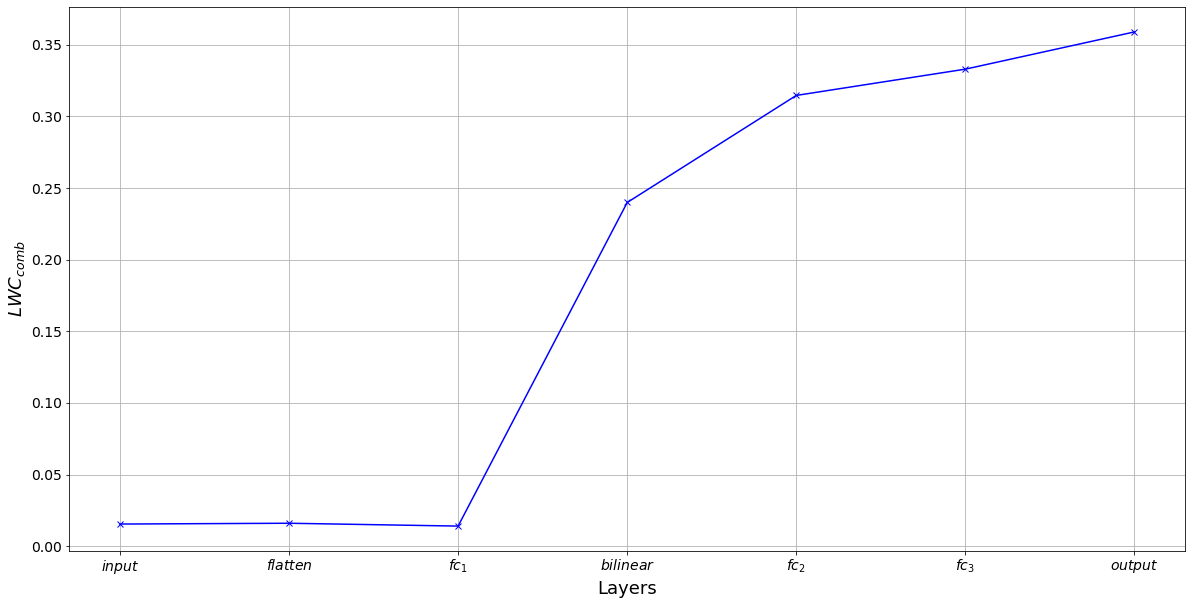

In [10]:
def LWC_comb(sbox_out, layer_output):
    median_mat = np.zeros((sbox_out.shape[0],1), dtype=np.float64, order='C')
    for i in range(0,sbox_out.shape[0]):
        temp = HW_byte[sbox_out[i]]
        median_mat[i,0] = temp
    corr_mat = Matrix_Cor(median_mat, layer_output)
    return corr_mat

layer_wise_corr = np.zeros((7), dtype = np.float64)
layer_wise_corr[0] = np.max(LWC_comb(Y_train_source[0:train_num], X_train_source[0:train_num,:].astype(np.float64)))
layer_wise_corr[1] = np.max(LWC_comb(Y_train_source[0:train_num], x0_out.astype(np.float64)))
layer_wise_corr[2] = np.max(LWC_comb(Y_train_source[0:train_num], x1_out.astype(np.float64)))
layer_wise_corr[3] = np.max(LWC_comb(Y_train_source[0:train_num], bilinear_x2_out.astype(np.float64)))
layer_wise_corr[4] = np.max(LWC_comb(Y_train_source[0:train_num], x3_out.astype(np.float64)))
layer_wise_corr[5] = np.max(LWC_comb(Y_train_source[0:train_num], x4_out.astype(np.float64)))
layer_wise_corr[6] = np.max(LWC_comb(Y_train_source[0:train_num], final_out.astype(np.float64)))

fig = plt.figure(figsize=(20,10))
fig3 = fig.add_subplot(1,1,1)
font1 = {
'weight' : 'normal',
'size'   : 18,
}
ticks = [r'$input$',r'$flatten$',r'$fc_1$',r'$bilinear$',r'$fc_2$',r'$fc_3$',r'$output$']
fig3.set_xlabel("Layers",font1)
fig3.set_ylabel(r"$LWC_{comb}$",font1)
labels = []
trace_num_max = 500
x = range(0, 7)
fig3.plot(x,layer_wise_corr, 'blue',marker='x')
plt.yticks(size = 14)
plt.xticks(x, ticks, rotation=0, fontproperties = 'Times New Roman', size = 14)
fig3.grid()
plt.show()